# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [17]:
MODEL_DIR

'/home/marziehhaghighi/workspace_DL/Mask_RCNN/logs'

In [2]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

In [3]:
# tf.compat.v1.disable_eager_execution()

## Configurations

In [2]:
class SpotsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "spots"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024#128
    IMAGE_MAX_DIM = 1024#128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = SpotsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [3]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import matthews_corrcoef
print(normalized_mutual_info_score([1, 1, 0, 0], [0, 0, 1, 1]))
print(matthews_corrcoef([1, 1, 0, 0], [0, 0, 1, 1]))

1.0
-1.0


In [29]:
A=np.array([1, 4, 0, 0,5,0])
B=np.array([1, 5, 0, 0])
# A.shape
# B=np.zeros(A.shape)

In [30]:
non_zero_ind=np.where(A!=0)[0]
zero_ind=np.where(A==0)[0]
non_zero_ind, zero_ind

(array([0, 1, 4]), array([2, 3, 5]))

In [32]:
A1=A[A!=0]
A1

array([1, 4, 5])

In [33]:
np.insert(A1, zero_ind, 0)

IndexError: index 7 is out of bounds for axis 0 with size 6

In [3]:
# import sklearn
# sklearn.metrics.consensus_score(A, B)

In [19]:
A=[1, 4, 0, 0]
B=[1, 5, 0, 0]
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('hamming')
X = [A,B]
dist.pairwise(X)[0,1]

0.25

In [44]:
dist.pairwise(X)

array([[0. , 0.5],
       [0.5, 0. ]])

In [10]:
a = np.array([1,2,3])
my_dict = {1:23, 2:34, 3:36, 4:45}
np.vectorize(my_dict.get)(a)


array([23, 34, 36])

In [42]:
dist.dist_to_rdist(X)

[[1, 2, 0, 0], [0, 0, 0, 0]]

In [31]:
matthews_corrcoef([1, 2, 0, 0], [0, 0, 0, 0])

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "ellipse")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        elif shape == "ellipse":
#             cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)
            cv2.ellipse(image, (x, y), (s,2*s),45,0, 360, color, -1)
            
            
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle", "ellipse"])
#         shape = random.choice(["square", "circle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
#         s = random.randint(buffer, height//4)
        s = random.randint(buffer, int(height//20))
        return shape, color, (x, y, s)
    

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(10, 30)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [22]:
# dataset_val.image_ids

In [28]:
dataset_val.source_class_ids

{'': [0], 'shapes': [0, 1, 2, 3]}

In [24]:
dataset_train.class_from_source_map

{'.0': 0, 'shapes.1': 1, 'shapes.2': 2, 'shapes.3': 3}

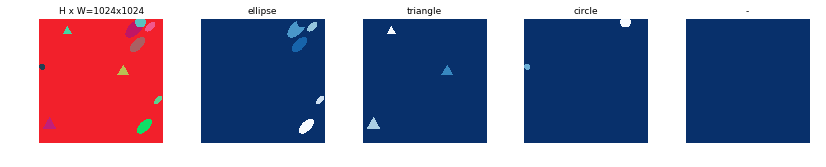

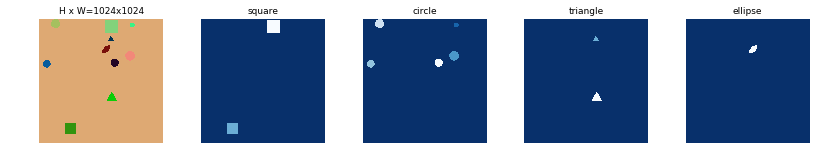

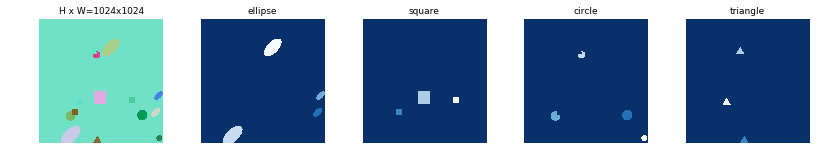

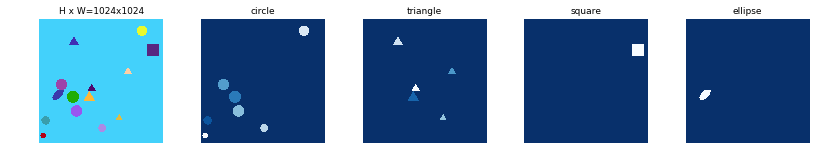

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="classification"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (8, ?)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)


In [10]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="clustering"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids_1:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets_1/target_class_ids:0", shape=(8, ?), dtype=int32)
gt_class_ids Tensor("input_gt_class_ids_1:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets_1/target_class_ids:0", shape=(8, ?), dtype=int32)
shared Tensor("pool_squeeze_1/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer_1:0", shape=(?, 32), dtype=int64)
clustering_labels Tensor("lambda_layer_1/kmeansclus:0", shape=(?, 32), dtype=int32)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)
pred_class_logits Tensor("mrcnn_class_loss_1/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids 

In [29]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit_transform([3,2,4,3,10]).shape

(5, 4)

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [17]:
# Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
dataset_train.

0.001

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200603T1947/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

  6/100 [>.............................] - ETA: 52:11 - loss: 7.7915 - rpn_class_loss: 0.5914 - rpn_bbox_loss: 1.6986 - mrcnn_class_loss: 2.4174 - mrcnn_bbox_loss: 1.9872 - mrcnn_mask_loss: 1.0969  [0 1 2 3 4] 1
map_dict {1: 0, 0: 4, 2: 3, 3: 2, 4: 1}
reassigned_labels [3 2 2 3 2 2 3 2 3 3 4 2 0 4 0 4 2 4 0 0 1 0 0 0 1 0 1 4 4 0 0 0 4 3 3 4 3
 3 2 4 1 3 3 4 0 0 4 0 4 1 0 0 0 1 0 0 0 0 4 0 0 0 0 0 2 2 3 4 2 2 3 2 2 2
 0 4 0 0 4 4 0 4 0 0 0 0 0 4 0 4 0 4 0 4 0 0 3 2 3 2 3 3 3 2 3 2 1 0 1 1 0
 1 0 4 0 0 4 1 1 0 0 1 1 0 0 1 0 0 2 0 2 2 3 3 3 2 0 0 4 4 0 1 0 4 1 0 1 0
 0 0 0 4 0 0 0 0 1 4 0 0 2 3 2 2 2 3 3 2 2 2 4 0 1 0 0 4 0 0 0 0 0 0 0 4 1
 0 4 0 0 0 0 0 2 2 3 3 2 2 2 3 2 3 0 3 4 4 0 2 0 4 0 0 0 1 1 0 1 1 0 0 4 0
 0 0 3 2 3 3 3 3 3 3 2 2 1 4 0 4 0 4 0 0 0 4 0 0 4 0 4 0 4 0 0 4 0 0]
gt_ids [[4 4 4 4 2 2 4 2 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 2 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2 4 2 2 2 4 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

 13/100 [==>...........................] - ETA: 24:26 - loss: 6.0057 - rpn_class_loss: 0.5101 - rpn_bbox_loss: 1.4100 - mrcnn_class_loss: 1.6635 - mrcnn_bbox_loss: 1.4420 - mrcnn_mask_loss: 0.9800[0 1 2 3 4] 1
map_dict {1: 0, 0: 2, 2: 3, 3: 4, 4: 1}
reassigned_labels [1 3 3 3 2 3 3 2 3 2 1 0 4 2 4 4 4 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 4 3 3 3 3
 1 3 3 1 2 0 0 1 4 0 4 0 0 1 4 4 0 0 4 0 0 0 4 0 0 0 0 3 3 2 4 2 0 4 2 2 0
 1 0 0 0 4 1 4 2 4 4 4 0 0 4 0 4 4 0 4 4 0 0 3 2 3 1 3 3 3 2 1 3 0 1 0 0 1
 1 1 0 1 0 4 1 0 0 0 4 1 0 3 1 0 0 2 0 2 2 0 3 0 3 3 2 0 4 0 4 4 0 0 0 4 4
 4 0 0 0 0 0 0 0 0 0 0 0 3 3 2 3 2 2 3 2 2 2 0 0 4 0 0 0 4 1 2 0 4 0 4 0 4
 0 0 0 0 0 0 0 2 2 0 2 2 2 2 2 2 1 0 4 4 4 4 4 0 1 0 0 4 0 0 4 0 2 0 4 4 4
 0 0 3 3 3 1 2 3 2 3 2 3 0 0 0 0 0 0 4 0 1 0 1 0 4 1 1 0 0 4 0 4 0 0]
gt_ids [[3 4 4 4 2 4 4 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 2 2 2 1 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 

 20/100 [=====>........................] - ETA: 15:53 - loss: 5.3267 - rpn_class_loss: 0.4018 - rpn_bbox_loss: 1.2369 - mrcnn_class_loss: 1.7220 - mrcnn_bbox_loss: 1.1214 - mrcnn_mask_loss: 0.8446[0 1 2 3 4] 2
map_dict {2: 0, 0: 1, 1: 4, 3: 3, 4: 2}
reassigned_labels [2 3 3 3 3 3 3 0 2 2 4 1 1 1 1 1 1 0 1 1 4 1 1 0 1 4 1 4 1 1 0 0 2 3 4 4 2
 0 4 3 0 4 4 4 1 4 1 4 4 1 1 4 0 1 4 1 1 0 1 1 4 4 0 0 2 3 0 2 2 0 2 2 2 4
 4 1 1 0 0 1 0 1 4 1 1 1 4 0 0 0 1 1 4 1 0 0 0 2 3 3 2 0 2 2 2 2 1 1 1 0 1
 0 1 1 4 1 0 1 4 1 4 1 0 1 1 1 0 0 0 3 0 3 2 0 2 2 2 2 1 1 0 4 3 1 0 1 1 4
 1 0 4 4 1 1 0 1 1 0 0 0 0 2 2 2 2 0 0 3 0 2 1 1 1 4 0 1 4 0 0 4 1 1 4 1 4
 1 1 4 4 0 0 0 2 0 2 2 0 0 3 0 0 3 1 1 4 1 0 1 1 1 1 4 1 1 4 4 4 0 4 1 1 1
 0 0 2 2 3 2 2 2 2 3 3 3 1 1 1 0 1 1 1 1 1 1 1 1 4 1 1 4 1 0 1 0 0 0]
gt_ids [[2 4 4 4 4 4 4 1 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 4 4 4 2 1 4 4 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 4 1 2 2 1 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 

 27/100 [=======>......................] - ETA: 11:39 - loss: 4.8082 - rpn_class_loss: 0.3175 - rpn_bbox_loss: 1.1213 - mrcnn_class_loss: 1.6537 - mrcnn_bbox_loss: 0.9360 - mrcnn_mask_loss: 0.7797[0 1 2 3 4] 1
map_dict {1: 0, 0: 3, 2: 2, 3: 4, 4: 1}
reassigned_labels [3 0 0 3 0 3 2 3 3 2 1 1 1 1 1 1 0 0 4 1 1 1 1 4 1 1 1 0 4 1 0 0 4 3 3 2 0
 3 0 0 2 2 1 1 1 0 1 1 4 4 4 1 0 0 0 1 0 1 1 0 0 4 0 0 4 0 2 2 2 4 4 0 2 3
 1 1 0 1 1 4 1 1 1 1 1 0 1 1 0 1 1 4 1 4 0 0 3 2 2 2 3 2 0 0 2 0 0 1 1 1 4
 0 4 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 3 2 2 2 0 2 3 2 0 0 4 4 1 4 4 1 0 1 1
 4 1 1 1 0 4 0 1 4 1 0 0 2 0 2 2 2 0 0 2 2 2 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1
 0 1 1 0 1 0 0 0 0 0 0 2 0 2 2 2 2 1 1 0 1 1 0 1 1 1 0 1 1 4 1 4 1 4 4 1 0
 0 0 2 3 3 2 2 2 1 2 0 1 4 4 1 1 1 1 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
gt_ids [[4 1 3 4 1 4 2 4 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 3 4 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 2 2 2 2 1 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 

 34/100 [=========>....................] - ETA: 9:00 - loss: 4.2835 - rpn_class_loss: 0.2635 - rpn_bbox_loss: 1.0457 - mrcnn_class_loss: 1.4827 - mrcnn_bbox_loss: 0.8078 - mrcnn_mask_loss: 0.6837[0 1 2 3 4] 2
map_dict {2: 0, 0: 1, 1: 3, 3: 2, 4: 4}
reassigned_labels [0 3 2 0 2 0 2 0 2 2 1 0 0 0 0 0 1 4 1 0 4 1 0 1 0 4 1 1 1 0 0 0 2 2 2 2 2
 3 2 2 3 3 1 0 1 4 0 1 4 1 1 1 4 1 1 0 1 0 1 0 0 4 0 0 3 2 3 3 2 2 3 2 3 2
 1 1 1 4 1 1 0 0 4 4 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 2 4 2 0 2 2 2 0 0 4 1 1
 4 4 1 0 1 1 2 1 0 4 0 4 4 0 1 0 0 0 2 3 2 0 2 2 0 2 2 4 0 0 1 0 1 0 1 1 1
 4 1 0 1 0 1 1 1 4 0 0 0 3 0 3 3 3 3 3 3 2 2 4 4 1 1 0 4 0 4 1 1 1 4 4 0 0
 4 1 1 1 0 0 0 2 0 2 3 0 2 3 2 1 3 0 1 1 1 1 1 1 4 1 4 1 4 1 4 1 1 1 1 1 0
 0 0 2 2 2 0 2 2 0 2 2 2 1 1 4 0 0 1 1 1 1 1 1 1 4 1 0 1 1 1 1 0 0 0]
gt_ids [[3 4 2 1 4 1 2 1 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 3 3 4 3 2 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 2 4 4 4 2 4 3 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1

 41/100 [===========>..................] - ETA: 7:09 - loss: 3.9291 - rpn_class_loss: 0.2273 - rpn_bbox_loss: 0.9875 - mrcnn_class_loss: 1.3910 - mrcnn_bbox_loss: 0.7103 - mrcnn_mask_loss: 0.6130[0 1 2 3 4] 0
map_dict {0: 0, 1: 1, 2: 4, 3: 2, 4: 3}
reassigned_labels [2 2 2 2 3 2 0 2 3 2 0 1 0 1 1 1 0 1 4 1 0 1 0 1 1 1 1 1 0 0 0 0 2 2 3 3 2
 3 3 2 2 2 1 1 4 2 1 0 0 4 1 1 0 1 0 0 1 1 0 0 0 1 0 0 2 3 3 3 3 2 3 2 2 2
 1 0 1 1 1 1 0 1 1 4 1 1 4 4 1 1 0 0 4 1 0 0 2 2 0 2 2 2 2 2 2 2 0 4 0 0 1
 4 0 0 4 0 4 0 1 4 1 0 1 4 1 0 0 0 2 2 2 2 2 3 2 2 0 2 1 1 1 4 4 0 0 0 1 4
 0 0 1 4 1 0 0 0 0 0 0 0 3 3 3 3 3 2 2 3 2 3 3 4 1 1 4 1 1 0 1 1 1 0 1 1 1
 1 1 1 0 4 0 0 3 2 2 3 2 3 2 2 2 1 1 1 1 1 0 0 1 1 1 4 1 4 1 0 0 1 1 1 0 4
 0 0 2 2 4 2 2 2 2 3 2 2 1 0 1 1 1 0 1 1 0 1 1 0 0 4 1 4 0 0 1 1 0 0]
gt_ids [[2 2 2 4 4 4 1 2 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2 4 4 4 4 4 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 4 4 4 4 3 4 4 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 2

 48/100 [=============>................] - ETA: 5:45 - loss: 3.5620 - rpn_class_loss: 0.2006 - rpn_bbox_loss: 0.9341 - mrcnn_class_loss: 1.2465 - mrcnn_bbox_loss: 0.6304 - mrcnn_mask_loss: 0.5504[0 1 2 3 4] 2
map_dict {2: 0, 0: 4, 1: 1, 3: 2, 4: 3}
reassigned_labels [3 2 0 0 3 0 2 2 2 0 0 4 0 1 0 1 0 2 1 1 1 1 0 1 1 0 4 0 0 1 0 0 2 3 2 3 2
 2 2 2 4 2 4 1 0 1 0 1 0 1 1 1 4 1 0 1 4 0 1 4 1 1 0 0 3 2 3 3 4 3 3 2 2 2
 4 1 0 4 4 0 0 0 1 4 0 1 1 1 1 1 4 1 0 0 0 0 3 2 1 2 2 2 2 2 3 1 4 1 4 0 1
 1 0 4 4 0 0 4 4 0 4 1 0 1 0 4 0 0 0 2 2 2 2 2 2 0 2 2 0 1 1 1 1 1 1 1 1 1
 1 1 1 4 0 4 0 4 0 1 0 0 2 2 3 2 2 2 3 3 3 3 0 1 4 1 1 4 1 1 1 1 1 1 1 4 1
 0 3 1 0 1 0 0 2 1 2 3 2 2 3 2 2 2 1 1 1 1 4 0 1 1 1 0 1 1 1 1 4 1 1 0 1 1
 0 0 2 2 2 2 2 0 3 2 2 2 0 1 1 0 0 1 2 1 1 1 0 1 0 1 2 0 1 0 1 0 0 0]
gt_ids [[4 4 1 1 4 1 3 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 4 3 4 3 3 2 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 3 4 4 3 4 4 2 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4

 55/100 [===============>..............] - ETA: 4:37 - loss: 3.2487 - rpn_class_loss: 0.1798 - rpn_bbox_loss: 0.8856 - mrcnn_class_loss: 1.1153 - mrcnn_bbox_loss: 0.5653 - mrcnn_mask_loss: 0.5027[0 1 2 3 4] 0
map_dict {0: 0, 1: 1, 2: 4, 3: 2, 4: 3}
reassigned_labels [0 0 0 2 2 2 3 2 2 2 4 0 0 4 4 4 1 1 4 4 4 3 1 0 4 0 1 0 1 4 0 0 2 3 3 2 2
 4 2 2 2 2 1 1 1 1 4 1 0 1 1 1 0 4 1 1 0 1 1 4 0 1 0 0 2 3 3 2 4 2 4 3 2 2
 0 1 1 1 0 1 4 1 4 1 4 0 1 1 1 0 0 0 1 0 0 0 0 2 2 2 2 2 3 2 2 2 4 2 1 0 1
 0 1 0 4 3 4 4 4 0 1 4 0 1 1 4 0 0 2 3 2 1 2 2 2 2 2 2 0 1 0 1 4 0 1 0 1 0
 0 1 1 1 1 0 4 0 1 1 0 0 2 2 2 3 3 0 2 3 2 2 1 4 0 4 1 0 1 0 0 0 1 1 0 0 0
 1 1 1 1 1 0 0 3 2 2 3 2 2 1 2 0 2 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 0 3 2 2 2 0 3 2 0 2 2 0 1 0 0 4 1 1 4 1 1 1 1 1 3 1 1 1 1 0 1 0 0]
gt_ids [[1 1 1 3 2 4 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 4 4 1 3 4 3 3 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 4 4 1 3 4 3 4 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2

 62/100 [=================>............] - ETA: 3:40 - loss: 2.9970 - rpn_class_loss: 0.1635 - rpn_bbox_loss: 0.8432 - mrcnn_class_loss: 1.0117 - mrcnn_bbox_loss: 0.5145 - mrcnn_mask_loss: 0.4641[0 1 2 3 4] 2
map_dict {2: 0, 0: 3, 1: 1, 3: 2, 4: 4}
reassigned_labels [3 3 3 0 2 3 0 2 0 2 2 4 4 4 4 0 1 4 0 4 1 2 0 1 1 1 0 4 0 3 0 0 2 3 2 2 2
 2 2 2 3 2 1 1 1 0 4 1 1 1 1 1 1 4 2 1 1 1 0 0 1 1 0 0 2 2 2 3 3 4 2 3 3 2
 1 1 4 4 1 1 4 1 1 1 1 0 1 4 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 4 4 1 4
 4 4 4 0 1 0 4 4 4 1 0 4 1 4 1 0 0 2 2 2 2 2 2 2 2 2 2 0 2 0 4 1 0 0 1 0 0
 1 1 1 1 1 0 0 4 1 0 0 0 3 2 3 3 2 3 3 3 2 2 1 1 1 4 1 1 1 1 1 1 4 4 1 0 1
 2 1 0 4 2 0 0 2 3 2 3 2 2 2 2 2 3 1 1 0 1 1 4 0 2 1 1 0 4 2 1 1 1 1 1 1 4
 0 0 3 2 2 2 2 3 2 2 2 2 1 1 1 1 1 1 1 1 0 1 1 1 1 4 1 0 0 1 1 0 0 0]
gt_ids [[4 4 4 3 4 4 1 3 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 4 3 2 2 4 2 2 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 2 4 4 4 3 3 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2

 69/100 [===================>..........] - ETA: 2:50 - loss: 2.8100 - rpn_class_loss: 0.1512 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.9322 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4318[0 1 2 3 4] 3
map_dict {3: 0, 0: 2, 1: 1, 2: 4, 4: 3}
reassigned_labels [3 3 2 2 2 3 3 3 2 2 4 3 0 4 0 0 0 1 1 0 0 1 1 1 1 4 0 0 4 1 0 0 2 2 3 2 3
 3 2 3 3 0 1 1 4 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 2 2 3 2 2 3 2 2
 4 0 1 4 1 1 0 1 0 2 1 4 0 1 4 1 1 1 4 0 0 0 2 3 2 0 3 2 2 3 2 2 0 0 1 0 1
 1 4 1 2 0 1 3 1 4 0 2 0 4 0 4 0 0 2 3 2 2 0 0 2 2 3 3 1 1 1 1 1 0 4 1 0 1
 1 0 0 0 0 4 0 0 2 1 0 0 2 2 2 3 3 2 2 2 2 2 0 0 4 2 0 1 0 4 1 2 0 2 1 1 1
 1 1 1 4 2 0 0 3 3 3 0 3 3 2 3 3 3 4 1 3 1 4 1 1 3 4 1 0 0 4 0 4 0 4 1 0 1
 0 0 3 3 2 3 3 2 2 2 2 3 0 1 1 1 1 1 4 1 1 1 1 1 4 1 4 1 1 1 1 0 0 0]
gt_ids [[4 4 1 2 3 4 4 4 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 3 2 3 2 4 3 2 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 4 4 4 4 3 2 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2

In [13]:
from sklearn.preprocessing import label_binarize
label_binarize([1, 6], classes=range(7))

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200601T2133/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 442s 4s/step - loss: 1.5674 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.7043 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2533 - mrcnn_mask_loss: 0.2684 - val_loss: 0.8294 - val_rpn_class_loss: 0.0342 - val_rpn_bbox_loss: 0.5035 - val_mrcnn_class_loss: 0.0948 - val_mrcnn_bbox_loss: 0.1104 - val_mrcnn_mask_loss: 0.0866


In [ ]:
 1/100 [..............................] - ETA: 3:59:11 - loss: nan - rpn_class_loss: 0.4325 - rpn_bbox_loss: 1.6060 - mrcnn_class_loss: nan - mrcnn_bbox_loss: 2.4804 - mrcnn_mask_loss: 0.4483Input Shape (8, 32, 1024)

In [ ]:
 45/100 [============>.................] - ETA: 5:44 - loss: 2.4823 - rpn_class_loss: 0.2034 - rpn_bbox_loss: 0.9265 - mrcnn_class_loss: 0.4083 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.4922

In [21]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [22]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(SpotsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head='def'
inference_config.assign_label_mode="clustering"
inference_config.DETECTION_MIN_CONFIDENCE=0.7
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)



# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

shared Tensor("pool_squeeze_2/Squeeze_1:0", shape=(?, 1000, 1024), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer_2:0", shape=(?, 1000), dtype=int64)
clustering_labels Tensor("lambda_layer_2/kmeansclus:0", shape=(?, 1000), dtype=int32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200603T0022/mask_rcnn_spots_0010.h5
Re-starting from epoch 10


In [53]:
model.load_weights(model_path, by_name=True)

Re-starting from epoch 1


In [12]:
original_image.dtype

dtype('uint8')

original_image           shape: (1024, 1024, 3)       min:    5.00000  max:  252.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (11,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (11, 4)               min:   91.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 11)      min:    0.00000  max:    1.00000  bool


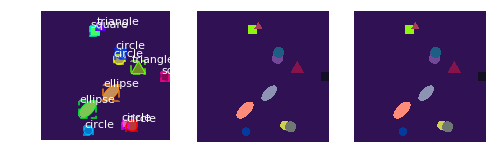

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [14]:
gt_class_id

array([2, 3, 4, 4, 2, 2, 3, 2, 4, 3, 3, 4, 2, 3, 4, 4, 4, 3, 2, 1, 2, 2,
       1, 2, 1, 3, 2], dtype=int32)

In [15]:
r['class_ids']

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1], dtype=int32)

In [16]:
# r['rois']

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    5.00000  max:  252.00000  uint8
image_meta (17,) [   0 1024 1024    3 1024 1024    3    0    0 1024 1024    1    0    0
    0    0    0]
(1, 17)
molded_images            shape: (1, 1024, 1024, 3)    min: -118.70000  max:  128.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


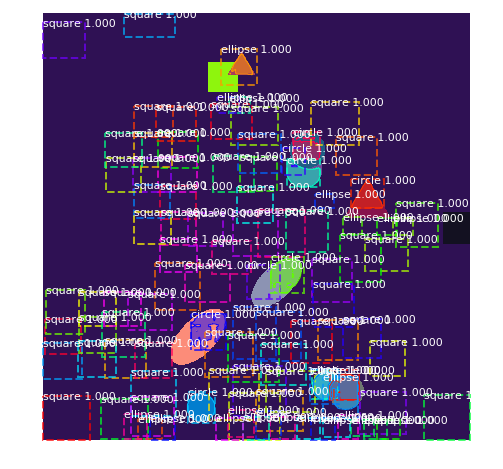

In [17]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [30]:
results

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [60]:
# results

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95


In [ ]:
Function for classification loss
def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.

In [ ]:
class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
    [target_class_ids, mrcnn_class_logits, active_class_ids])

In [ ]:
rois, target_class_ids, target_bbox, target_mask =\
    DetectionTargetLayer(config, name="proposal_targets")([
        target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

In [ ]:
class DetectionTargetLayer(KE.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

In [ ]:
I want to manipulate conversion of "gt_class_ids" to "target_class_ids"\
in the above function for clustering samples and reassign the labels 

In [16]:
# import tensorflow as tf
from tensorflow.contrib.factorization import KMeans

/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Change:
mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                     config.POOL_SIZE, config.NUM_CLASSES,
                     train_bn=config.TRAIN_BN,
                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

In [ ]:
# ------------------------------------------
# TensorFlow Implementation for kmeans
# ------------------------------------------
# Extract the features from the training data
feats = tf.contrib.learn.infer_real_valued_columns_from_input(x_train)
# Building a 3-layer DNN with 50 units each.
classifier_tf = tf.contrib.learn.DNNClassifier(feature_columns=feats, 
                                               hidden_units=[50, 50, 50], 
                                               n_classes=3)
# Use the train data to train this classifier
classifier_tf.fit(x_train, y_train, steps=5000)
# Use the trained model to predict on the test data
predictions = list(classifier_tf.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, predictions)

In [22]:
tf.contrib.learn.infer_real_valued_columns_from_input

<function tensorflow.contrib.learn.python.learn.estimators.estimator.infer_real_valued_columns_from_input(x)>

In [ ]:
kmeans = tf.contrib.factorization.KMeans(
  inp,
  num_clusters,
  distance_metric=tf.contrib.factorization.COSINE_DISTANCE,
  # TODO(agarwal): kmeans++ is currently causing crash in dbg mode.
  # Enable this after fixing.
  # initial_clusters=tf.contrib.factorization.KMEANS_PLUS_PLUS_INIT,
  use_mini_batch=True)

all_scores, _, clustering_scores, kmeans_training_op = kmeans.training_graph()

In [26]:
tf.contrib.learn.KMeans

AttributeError: module 'tensorflow.contrib.learn' has no attribute 'KMeans'

In [27]:
tf.contrib.factorization.KMeansClustering

tensorflow.contrib.factorization.python.ops.kmeans.KMeansClustering

In [4]:
k = 5
n = 100
variables = 2
points = np.random.uniform(0, 1000, [n, variables])
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)
kmeans=tf.contrib.factorization.KMeansClustering(num_clusters=k, use_mini_batch=False)
previous_centers = None
# for _ in range(10):
kmeans.train(input_fn)
centers = kmeans.cluster_centers()
#   if previous_centers is not None:
#     print 'delta:', centers - previous_centers
#   previous_centers = centers
#   print 'score:', kmeans.score(input_fn)
# print 'centers:', centers
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
#   print 'point:', point, 'is in cluster', cluster_index, 'centered at', centers[cluster_index]

NameError: name 'tf' is not defined

In [41]:
len(cluster_indices)

100

In [47]:
testT=tf.convert_to_tensor(points, dtype=tf.float32)
testT

<tf.Tensor 'Const_4:0' shape=(100, 2) dtype=float32>

In [53]:
tf.reshape(
    testT, (testT.shape[1],testT.shape[0]), name=None
)

<tf.Tensor 'Reshape_7:0' shape=(2, 100) dtype=float32>

Dimension(100)

# Clustering details:
- test both of the following, when doing clustering at each iteration:
    - Predict based on random initialization at first at the first iteration, then for the next one instialize clusters based on predictions 
    - At each iteration permute labels so that it has the minimum hamming distance to the predicted ones 

In [18]:
cost = np.array([[4, 1, 3],
                 [2, 0, 5],
                 [3, 2, 2],
                 [3, 2, 2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)
col_ind


array([1, 0, 2])

In [17]:
Input Shape (8, 32, 1024)

array([1, 3, 4])

In [ ]:
X=np.array([[[1,1,1],[2,2,2],[3,3,3]],
           [[4,4,4],[5,5,5],[6,6,6]],
           [[7,7,7],[8,8,8],[9,9,9]],
           [[10,10,10],[11,11,11],[12,12,12]]])

In [28]:
X1=np.array([[1,2,3],
           [4,5,6],
           [7,8,9],
           [10,11,12]])




In [30]:
X1.flatten()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [26]:
X.shape

(4, 3, 3)

In [27]:
X.reshape([12,3])

array([[ 1,  1,  1],
       [ 2,  2,  2],
       [ 3,  3,  3],
       [ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       [ 7,  7,  7],
       [ 8,  8,  8],
       [ 9,  9,  9],
       [10, 10, 10],
       [11, 11, 11],
       [12, 12, 12]])

In [16]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# kmeans.labels_
# array([1, 1, 1, 0, 0, 0], dtype=int32)
# kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)
cents=kmeans.cluster_centers_
cents

array([[10.,  3.],
       [ 1.,  2.],
       [10.,  0.]])

In [42]:
from numpy import linalg as LA
np.argmin(LA.norm(cents-[10,0],1,axis=1))

2

In [19]:
list(kmeans.labels_).remove(0)

In [23]:
b=list(kmeans.labels_)
b.remove(0)
b

[1, 1, 1, 0, 2]

In [22]:
b